In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from importlib import  reload
import sys
from imp import  reload
import warnings  
import nltk
from nltk.tokenize import word_tokenize
import re
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

warnings.filterwarnings('ignore')
if sys.version[0] == '2':
  reload(sys)
  sys.setdefaultencoding("utf-8")
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [2]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
#importing data
tsv_read = pd.read_csv("train.tsv", sep='\t')
df = tsv_read


In [4]:
#preprocessing

df= df.reset_index(drop=True)
symbols = re.compile('[/(){}\[\]\|@,;]')
symbols_1 = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() #lowercase
    text = symbols.sub(' ', text) # replacing symbols by space in text
    text = symbols_1.sub('', text) # removing symbols_1 
    return text
df['Phrase'] = df['Phrase'].apply(clean_text)



In [5]:
# Tokenizing the data and converting to numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Phrase'].values)
inputs = tokenizer.texts_to_sequences(df['Phrase'].values)


In [6]:
MAX_LENGTH = 35
inputs = pad_sequences(inputs, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Max Length is", MAX_LENGTH)

Max Length is 35


In [7]:
# Use train_test_split to split our data into train and validation sets for
# training (80-20)
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, df['Sentiment'], 
                                                          random_state=1, test_size=0.2)



In [8]:
train_inputs = torch.tensor(train_inputs, dtype=torch.long)
test_inputs = torch.tensor(test_inputs,  dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
#test_labels = torch.tensor(test_labels,  dtype=torch.long)

In [9]:
# Pre-process the labels to one-hot encodings
rows=len(train_labels)
new_train_labels=np.zeros((rows,5))
for i in range(rows):
  new_train_labels[i, train_labels[i]] = 1
new_train_labels=torch.tensor(new_train_labels)

In [10]:
#Attention Layer
class Attention(tf.keras.Model):
   def __init__(self, units):
        super(Attention, self).__init__()
        self.weights1 = tf.keras.layers.Dense(units)
        self.weights2 = tf.keras.layers.Dense(units)
        self.total = tf.keras.layers.Dense(1)

   def call(self, words, hidden):
        hidden_expanded = tf.expand_dims(hidden, 1)
        word_score = tf.nn.tanh(
            self.weights1(words) + self.weights2(hidden_expanded))
        attention_weights = tf.nn.softmax(self.total(word_score), axis=1)
        contribution = attention_weights * words
        contribution = tf.reduce_sum(contribution, axis=1)
        return contribution, attention_weights


In [11]:
#Embedding Layer
input_seq = Input(shape=(MAX_LENGTH,), dtype="int32")
seq_embed = Embedding(vocab_size, MAX_LENGTH, input_length=MAX_LENGTH, embeddings_regularizer=keras.regularizers.l2(.001))(input_seq)

In [12]:
#Running bidirectional LSTM 
cell_size = 100
lstm = Bidirectional(LSTM(cell_size, return_sequences = True), name="LSTM_L1")(seq_embed)

(lstm, fwd_hidden, fwd_cell, bwd_hidden, bwd_cell) = Bidirectional(LSTM(cell_size, return_sequences=True, return_state=True), name="LSTM_L2")(lstm)

In [13]:
#Defining the model 
hidden_state = Concatenate()([fwd_hidden, bwd_hidden])
cell_state = Concatenate()([fwd_cell, bwd_cell])
contribution, attention_weights = Attention(10)(lstm, hidden_state)
dense1 = Dense(20, activation="relu")(contribution)
dropout = Dropout(0.05)(dense1)
output = Dense(5, activation="softmax")(dense1)
  
model = keras.Model(inputs=input_seq, outputs=output)


In [14]:
METRICS = [keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),]

model.compile(loss='categorical_crossentropy',  
              optimizer='adam',
              metrics=METRICS)

In [15]:
BATCH_SIZE = 64
EPOCHS = 5
train_inputs=np.array(train_inputs)
new_train_labels=np.array(new_train_labels)
history = model.fit(train_inputs,new_train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
1561/1561 [==============================] - 114s 65ms/step - loss: 1.1606 - accuracy: 0.5630 - precision: 0.6787 - recall: 0.4096 - val_loss: 1.0576 - val_accuracy: 0.6091 - val_precision: 0.6732 - val_recall: 0.4984
Epoch 2/5
1561/1561 [==============================] - 99s 63ms/step - loss: 1.0013 - accuracy: 0.6347 - precision: 0.6933 - recall: 0.5259 - val_loss: 0.9792 - val_accuracy: 0.6394 - val_precision: 0.6900 - val_recall: 0.5405
Epoch 3/5
1561/1561 [==============================] - 99s 63ms/step - loss: 0.9366 - accuracy: 0.6547 - precision: 0.7014 - recall: 0.5725 - val_loss: 0.9517 - val_accuracy: 0.6476 - val_precision: 0.6920 - val_recall: 0.5621
Epoch 4/5
1561/1561 [==============================] - 99s 64ms/step - loss: 0.8982 - accuracy: 0.6684 - precision: 0.7075 - recall: 0.5966 - val_loss: 0.9349 - val_accuracy: 0.6523 - val_precision: 0.6874 - val_recall: 0.5900
Epoch 5/5
1561/1561 [==============================] - 101s 65ms/step - loss: 0.8715 - accu

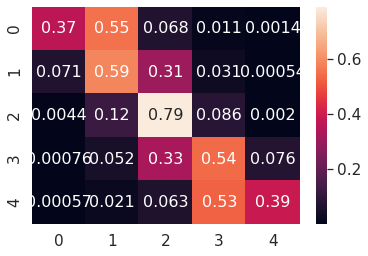

In [16]:
test_inputs=np.array(test_inputs)
prediction = model.predict(test_inputs)
prediction1 = np.argmax(prediction, axis = 1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd

conf=confusion_matrix(test_labels, prediction1)
conf_normalized = confusion_matrix(test_labels, prediction1, normalize='true')

df_cm = pd.DataFrame(conf_normalized, range(5), range(5))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 
plt.show()


In [17]:
# Accuracy, recall and precision

accuracy=sum(np.diag(conf))/np.sum(conf)
print("Accuracy is", accuracy*100, "%")

recall = np.zeros(5)
precision = np.zeros(5)
for i in range(5):
  recall[i] = round((conf[i, i] / np.sum(conf[:, i])) * 100, 2)
  precision[i] = round((conf[i, i] / np.sum(conf[i, :])) * 100, 2)

recall = pd.DataFrame(recall)
precision = pd.DataFrame(precision)
eval = pd.concat([recall, precision], axis = 1)
eval.columns = ['Recall (%)', 'Precision (%)']
print(eval)

Accuracy is 65.92015891323851 %
   Recall (%)  Precision (%)
0       52.73          36.72
1       51.24          59.02
2       75.57          78.69
3       58.89          54.24
4       56.20          38.80
